## Import sections and convert

In [150]:
import geopandas as gpd
import pandas as pd
import rasterio
from shapely.geometry import shape, Polygon, LineString, Point
from map2loop import m2l_utils
%matplotlib inline


,Id,geometry
0,0,LINESTRING (506801.4794552447 7454777.97830053...


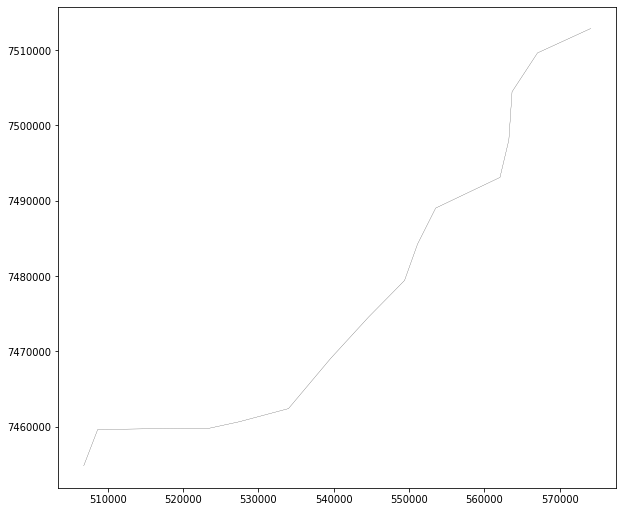

In [56]:
seismic_line_file='../test_data3/data/seismic_line_10GA-CP1_rev.shp'   #input geology file (if local)

seismic_line = gpd.read_file(seismic_line_file) #import map

seismic_line.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2) #display map
display(seismic_line)


,Id,DEPTH,geometry
POSITION,,,
TL,0,0.0,POINT (1050.652495082834 -746.6807596135791)
TR,0,0.0,POINT (2157.11115736801 -743.8452167779411)
BR,0,20000.0,POINT (2157.260396464622 -919.7234921357884)


Id                                                     0
DEPTH                                              20000
geometry    POINT (2157.260396464622 -919.7234921357884)
Name: BR, dtype: object

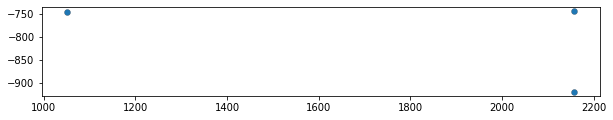

In [57]:
seismic_bbox_file='../test_data3/data/seismic_bbox.shp'   #input geology file (if local)

seismic_bbox = gpd.read_file(seismic_bbox_file) #import map

seismic_bbox.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2) #display map
seismic_bbox.set_index('POSITION',inplace=True)
display(seismic_bbox,seismic_bbox.loc['BR'])

,Id,FEATURE,IDENT,geometry
0,0,Fault,Moona_Fault,LINESTRING (1730.227349563404 -741.33526691666...
1,0,Fault,Soda_Fault,LINESTRING (1353.026617587855 -740.32144915983...
2,0,Fault,None,LINESTRING (1737.425916678116 -739.96045390749...
3,0,Fault,None,LINESTRING (1361.318177417732 -740.08972276443...
4,0,Fault,None,LINESTRING (1376.054827108636 -739.96045390749...
5,0,Fault,Karra_Well_Fault,LINESTRING (1459.368605405016 -739.57264733668...
6,0,Fault,None,LINESTRING (1441.141696576793 -739.83118505056...
7,0,Fault,None,LINESTRING (1262.51772998569 -753.007505850086...
8,0,Fault,None,LINESTRING (1204.145659475133 -745.65354421096...
9,0,Fault,None,LINESTRING (1196.332075233562 -745.88335551218...


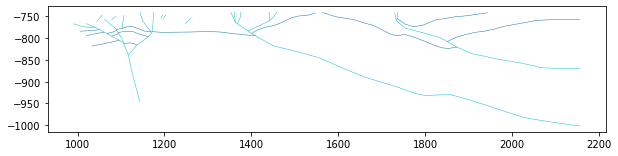

In [164]:
seismic_interp_file='../test_data3/data/seismic_interp.shp'   #input geology file (if local)

seismic_interp = gpd.read_file(seismic_interp_file) #import map

seismic_interp.plot(column='FEATURE',figsize=(10,10),edgecolor='#000000',linewidth=0.5) #display map
display(seismic_interp)

In [165]:
dtm_reproj_file='../test_data3/dtm/dtm_rp.tif'
dtm = rasterio.open(dtm_reproj_file)


def to convert section x,y to real_world x,y,z based on dtm & seismic line m2l_section.section2model()
parse section geodataframe and save fault location info below buffer depth m2l_section.process_faults()
parse section geodataframe and save basal contact location info below buffer depth m2l_section.process_strat()
parse section geodataframe and process fault-fault topology and fault-strat topology and strat topology m2l_section.process_topology()



In [166]:
def bboxscale(seismic_bbox):
    xscale=seismic_bbox.loc['TR'].geometry.x-seismic_bbox.loc['TL'].geometry.x
    yscale=seismic_bbox.loc['TR'].geometry.y-seismic_bbox.loc['BR'].geometry.y
    return(xscale,yscale)

xscale,yscale=bboxscale(seismic_bbox)

print(xscale,yscale)

1106.4586622851757 175.87827535784731


In [167]:
def section2model(seismic_line,seismic_bbox,sx,sy):
    sx1=(sx-seismic_bbox.loc['TL'].geometry.x)/(seismic_bbox.loc['TR'].geometry.x-seismic_bbox.loc['TL'].geometry.x)
    sy1=(sy-seismic_bbox.loc['TR'].geometry.y)
    for indx,lines in seismic_line.iterrows():
        s_ls=LineString(lines.geometry)
        first=True
        cdist=0
        for seg in s_ls.coords:        
            if(not first):
                dist=m2l_utils.ptsdist(seg[0],seg[1],lsegx,lsegy)
                cdist=cdist+dist
                lsegx=seg[0]
                lsegy=seg[1]
            else:
                first=False
                lsegx=seg[0]
                lsegy=seg[1]
        break
    
    full_dist=cdist
    
    for indx,lines in seismic_line.iterrows():
        s_ls=LineString(lines.geometry)
        first=True
        cdist=0
        for seg in s_ls.coords:        
            if(not first):
                dist=m2l_utils.ptsdist(seg[0],seg[1],lsegx,lsegy)
                cdist=cdist+dist
                norm_dist=cdist/full_dist
                if(sx1>last_norm_dist and sx1<norm_dist):
                    local_norm=((sx1-last_norm_dist)/(norm_dist-last_norm_dist))
                    mx=lsegx+((seg[0]-lsegx)*local_norm)
                    my=lsegy+((seg[1]-lsegy)*local_norm)
                    return(mx,my)
                lsegx=seg[0]
                lsegy=seg[1]
                last_norm_dist=norm_dist
            else:
                first=False
                lsegx=seg[0]
                lsegy=seg[1]
                last_norm_dist=0
        return(-999,-999)
    


In [168]:
sx,sy=1730.227349563404, -751.33526691666

mx,my=section2model(seismic_line,seismic_bbox,sx,sy)
print(mx,my)

552036.946637345 7486034.912080014


In [199]:
def extract_section(tmp_path,output_path,seismic_line,seismic_bbox,seismic_interp,dtm):
    fault_clip_file=tmp_path+'faults_clip.shp'   
    faults = gpd.read_file(fault_clip_file) #import faults    
    all_sorts=pd.read_csv(tmp_path+'all_sorts2.csv',",")
    sf=open(output_path+'seismic_faults.csv',"w")
    sf.write('X,Y,Z,formation\n')
    sb=open(output_path+'seismic_base.csv',"w")
    sb.write('X,Y,Z,formation\n')
    for indx,interps in seismic_interp.iterrows():
        i_ls=LineString(interps.geometry)
        for seg in i_ls.coords:
            mx,my=section2model(seismic_line,seismic_bbox,seg[0],seg[1])
            if( mx != -999 and  my != -999):
                mz=seismic_bbox.loc['BR']['DEPTH']*(seismic_bbox.loc['TR'].geometry.y-seg[1])/(seismic_bbox.loc['TR'].geometry.y-seismic_bbox.loc['BR'].geometry.y)
                locations=[(mx,my)]
                height= m2l_utils.value_from_raster(dtm,locations)
                if(not height==-999):
                    mz=mz+float(height)
                    if(str(interps['IDENT'])=='None'):
                        ident='None'
                    else:
                        ident=str(interps['IDENT'])
                    if('Base' in interps['FEATURE']):
                        maxfm=0
                        maxname=''
                        for indx,formation in all_sorts.iterrows():
                            if(formation['group'] in interps['IDENT'] and formation['index in group']>maxfm):
                                maxfm=formation['index in group']
                                maxname=formation['code']
                        ostr=str(mx)+','+str(my)+','+str(-mz)+','+maxname+'\n'
                        sb.write(ostr)
                    else:
                        for indx,aflt in faults.iterrows():
                            if(not str(aflt['NAME'])=='None' and not ident == 'None'):
                                fname=aflt['NAME'].replace(" ","_")
                                if(fname in interps['IDENT'] ):
                                    fault_id='Fault_'+str(aflt['OBJECTID'])
                                    ostr=str(mx)+','+str(my)+','+str(-mz)+','+fault_id+'\n'
                                    sf.write(ostr)
                                    break
    sf.close()
    sb.close()

In [200]:
tmp_path='../test_data3/tmp/'
output_path='../test_data3/output/'

extract_section(tmp_path,output_path,seismic_line,seismic_bbox,seismic_interp,dtm)

In [171]:
all_sorts=pd.read_csv('../test_data3/tmp/all_sorts2.csv',",")
display(all_sorts)

,index,group number,index in group,number in group,code,group
0,0,1,1,3,P__WYm_sp,Wyloo_Group
1,1,1,2,3,P__WYa_st,Wyloo_Group
2,2,1,3,3,P__WYd_kd,Wyloo_Group
3,3,2,1,2,P__SKq_stq,Shingle_Creek_Group
4,4,2,2,2,P__SKb_bb,Shingle_Creek_Group
5,5,3,1,4,P__TKa_xs_k,Turee_Creek_Group
6,6,3,2,4,P__TKo_stq,Turee_Creek_Group
7,7,3,3,4,P__TKk_sf,Turee_Creek_Group
8,8,3,4,4,P__TK_s,Turee_Creek_Group
9,9,4,1,7,P__HAo_ci,Hamersley_Group


In [172]:
maxfm=0
maxname=''
for indx,formation in all_sorts.iterrows():
    if(formation['group'] in 'Fortescue_Group' and formation['index in group']>maxfm):
        maxfm=formation['index in group']
        maxname=formation['code']
print('base fm =',maxfm,maxname)

base fm = 8 A_FOr_b


In [175]:
fault_clip_file='../test_data3/tmp/faults_clip.shp'   

faults = gpd.read_file(fault_clip_file) #import faults
display(faults)

,OBJECTID,FEATURE,TYPE,NAME,CODE,DIP,DIP_EST,DIP_DIR,PLUNGE,PLUNGE_EST,PLUNGE_DIR,MAX_AGE_EV,MIN_AGE_EV,SYMBOL,EXTRACT_DA,Shape_Leng,geometry
0,5475,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.042940,LINESTRING (537479.4876275827 7491875.60528064...
1,12644,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.219922,LINESTRING (570368.8123870555 7496845.96090111...
2,2235,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.191623,LINESTRING (525375.306361279 7483424.968661134...
3,11442,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.118887,LINESTRING (573949.2678682947 7488525.01030280...
4,3496,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.212902,LINESTRING (534630.3444196425 7483865.05492077...
5,5298,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.077828,LINESTRING (509508.6428913519 7495457.83221141...
6,12647,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.178653,LINESTRING (520343.178845656 7501712.978961742...
7,2997,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.144270,LINESTRING (545893.9824405949 7489525.86523723...
8,1236,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.058439,LINESTRING (569405.4426076568 7496423.33170704...
9,16455,Fault or shear zone,exposed,None,None,0,None,None,0,None,None,None,None,Fault or shear zone; exposed,2016-06-30,0.106503,LINESTRING (556810.039340778 7496760.771355649...


In [179]:
for indx,aflt in faults.iterrows():
    if(not str(aflt['NAME'])=='None'):
        fname=aflt['NAME'].replace(" ","_")
        if(fname in 'Coppin_Fault' ):
            fault_id='Fault_'+str(aflt['OBJECTID'])
            print(fname,fault_id)
            break

Coppin_Fault Fault_6825
